<a href="https://colab.research.google.com/github/mshaek/LoanPredictionApp/blob/main/notebooks/MoneyLion_Repayment_Mahfuzur_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import important Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load preprocessed data with merging 'loan' and 'underwriting' dataset
data = pd.read_csv('https://raw.githubusercontent.com/mshaek/LoanPredictionApp/main/data/merged.csv')
data

,apr,hasCF,target,clearfraudscore,inquiry.oneminuteago,ssnLoanCount,HoursTaken,log_originallyScheduledPaymentAmount,log_loanAmount,log_nPaidOff,log_leadCost,payFrequency_B,payFrequency_I,payFrequency_M,payFrequency_S,payFrequency_W,state_AK,state_AL,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MD,state_MI,state_MN,state_MO,state_MS,state_NC,state_ND,state_NE,state_NJ,state_NM,state_NV,state_OH,state_OK,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_WA,state_WI,state_WY,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,199.0,1,0,879.0,3.0,1,17,8.763458,8.006701,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,490.0,1,0,835.0,1.0,4,0,8.106147,7.131699,1.098612,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,590.0,1,0,624.0,3.0,1,53,7.796913,6.685861,0.000000,2.397895,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,404.1,1,0,770.0,3.0,3,12,6.048884,5.707110,1.386294,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,315.0,1,1,932.0,1.0,3,0,7.964250,7.313887,1.098612,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29513,645.0,1,0,925.0,4.0,1,0,8.539456,7.313887,0.000000,3.258097,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29514,565.0,0,0,763.5,3.0,1,0,7.421285,6.398595,1.386294,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
29515,645.0,1,0,700.0,3.0,1,0,6.950240,5.929589,0.000000,3.258097,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29516,449.0,1,0,806.0,3.0,1,20,6.499967,5.993961,0.000000,3.713572,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Separate input features and target
x_data = data.drop(columns=['target'])
y_data = data['target'].astype('category')

In [ ]:
# Shuffle and split data into 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_data, y_data,random_state=123, test_size=0.30)


In [ ]:
# Create a dictionary to store accuracy and AUC scores of all models for visualization later
model_scores = {}

In [ ]:
# Data Scaling is important for Neural Networks to prevent overfitting and exploding/vanishing gradient
from sklearn.preprocessing import StandardScaler
# created scaler
scaler = StandardScaler()
# fit and transform training dataset
xtrain= scaler.fit_transform(xtrain)
# transform test dataset
xtest= scaler.transform(xtest)


In [ ]:
# Data Scaling is important for Neural Networks to prevent overfitting and exploding/vanishing gradient
from sklearn.preprocessing import QuantileTransformer
# created scaler
scaler = QuantileTransformer(output_distribution= 'normal', random_state=0)
# fit and transform training dataset
xtrain= scaler.fit_transform(xtrain)
# transform test dataset
xtest= scaler.transform(xtest)

In [ ]:
xtrain

array([[-1.38462826,  5.19933758,  0.70392179, ...,  5.19933758,
        -5.19933758, -5.19933758],
       [ 0.21235277,  5.19933758,  0.09045214, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.54378913,  5.19933758,  0.67843252, ..., -5.19933758,
        -5.19933758, -5.19933758],
       ...,
       [-1.38462826,  5.19933758, -1.70557043, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-1.38462826,  5.19933758, -0.34814974, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-2.60672716,  5.19933758, -1.24206057, ..., -5.19933758,
        -5.19933758, -5.19933758]])

## Data Modelling and Parameter Tuning
* 4 models has been used to perform data modelling. These are Random Forest, XGBoost, Logistic Regression and Neural Networks.
* Feature selection is not needed for Random Forest and XGBoost.
* Random Forest and XGBoost are robust to the outliers
* Confusion Matrix will be shown and Cross-validation will be performed. 
* Model Performance will be compared using AUC score on validation dataset

In [ ]:
# function for evaluation metrics
def model_evaluation(model, ytest, y_pred, plot=False):
   
# Confusion Marix and Visualisations
    confusion = confusion_matrix(ytest, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    accuracy = metrics.accuracy_score(ytest, y_pred)
    print('TP:', TP)
    print('TN:', TN)
    print('FP:', FP)
    print('FN:', FN)
    
    AUC= metrics.roc_auc_score(ytest, y_pred)
    #CV_AUC = cross_val_score(model, x_data, y_data, cv=10, scoring='roc_auc').mean()
    print('Classification Accuracy:', accuracy)    
    print('F1 Score:',f1_score(ytest, y_pred))
    print('AUC Score:',AUC)
    #print('Cross-validated AUC:', CV_AUC)
  
    return accuracy, AUC

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss,f1_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# Building and fitting random_forest
random_forest =RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 50, random_state = 123)
random_forest.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

########### Random Forests ###############


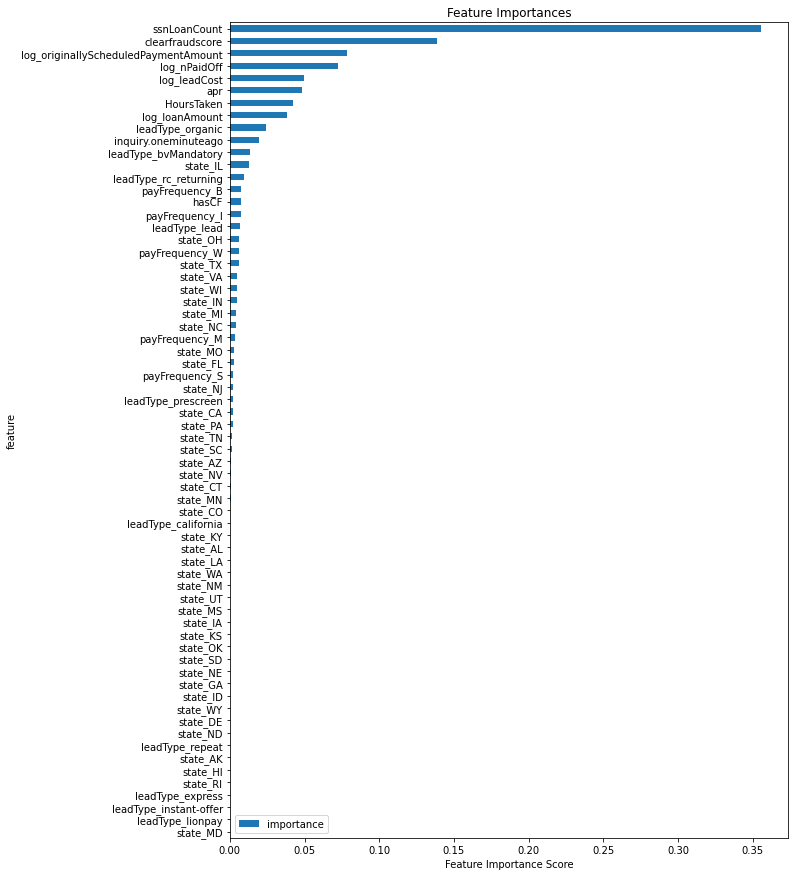

In [ ]:
print('########### Random Forests ###############')
feat_imp = pd.DataFrame({'importance':random_forest.feature_importances_})    
feat_imp['feature'] = x_data.columns
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", figsize=(10,15))
plt.xlabel('Feature Importance Score')
plt.show()

In [ ]:
# make class predictions for the testing set
y_pred_class_rf = random_forest.predict(xtest)

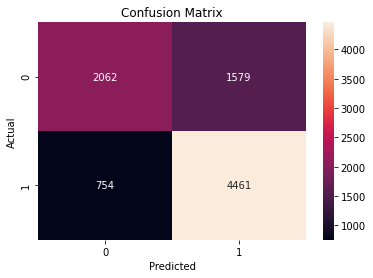

TP: 4461
TN: 2062
FP: 1579
FN: 754
Classification Accuracy: 0.7365627822944896
F1 Score: 0.792714349178143
AUC Score: 0.7108724990210827


In [ ]:
accuracy_score_random_forest = model_evaluation(random_forest, ytest, y_pred_class_rf, True)

model_scores['Random Forest'] = accuracy_score_random_forest[1] * 100

## XGBoost

In [ ]:
from scipy.stats import randint
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
xgModel = XGBClassifier()
xgModel.fit(xtrain, ytrain)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

########### XGBoost ###############


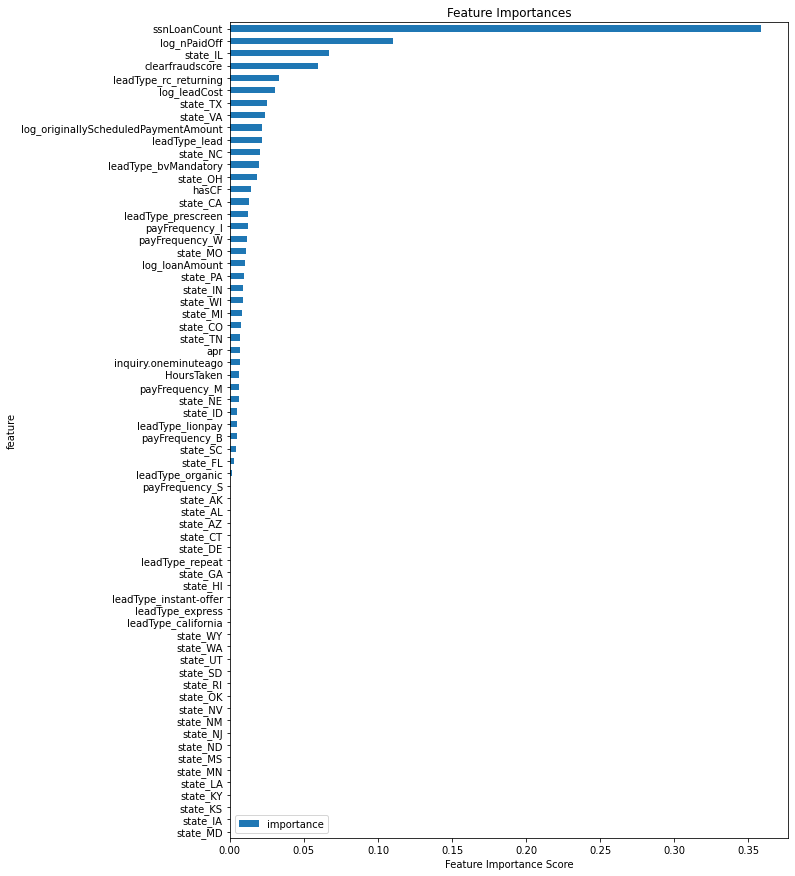

In [ ]:
print('########### XGBoost ###############')
feat_imp = pd.DataFrame({'importance':xgModel.feature_importances_})    
feat_imp['feature'] = x_data.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)

feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", figsize=(10,15))
plt.xlabel('Feature Importance Score')
plt.show()

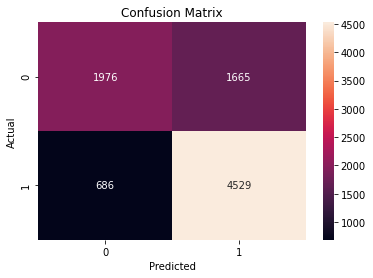

TP: 4529
TN: 1976
FP: 1665
FN: 686
Classification Accuracy: 0.7345302619692864
F1 Score: 0.7939346130248051
AUC Score: 0.7055822115393479


In [ ]:
# make class predictions for the testing set
y_pred_xgModel = xgModel.predict(xtest)

accuracy_score = model_evaluation(xgModel, ytest, y_pred_xgModel, True)

model_scores['XGBClassifier'] = accuracy_score[1] * 100

In [ ]:
#Hyperparameter tuning of XGBoost Classifier
param_distributions={'max_depth': np.arange(1, 5,1),
                    'subsample': uniform(0.25, 0.75),
                    'colsample_bytree': uniform(0.25, 0.75),
                    "learning_rate": [0.05, 0.1,0.16]
                    }

rs = RandomizedSearchCV(xgModel,
                        param_distributions,
                        cv=10,
                        n_iter=10,
                        scoring="accuracy",
                        n_jobs=1,
                        verbose=False,
                        random_state=123)
rs.fit(xtrain, ytrain)
y_pred_xgModel_cv = rs.predict(xtest)


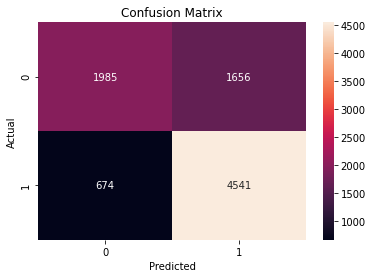

TP: 4541
TN: 1985
FP: 1656
FN: 674
Classification Accuracy: 0.7369015356820234
F1 Score: 0.7958289519803715
AUC Score: 0.7079686630610209


In [ ]:
model_score_xgboost_cv= model_evaluation(rs, ytest, y_pred_xgModel_cv, True)
model_scores['XGBoost_CV'] = model_score_xgboost_cv[1] * 100

In [ ]:
rs.best_params_

{'colsample_bytree': 0.5507631674959026,
 'learning_rate': 0.05,
 'max_depth': 4,
 'subsample': 0.4931131700346558}

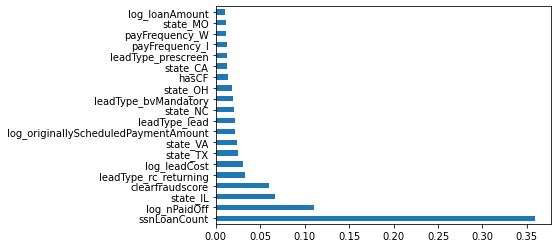

In [ ]:
#plot graph of feature importances for better visualization
from xgboost import plot_importance
feat_importances = pd.Series(xgModel.feature_importances_, index=x_data.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
rs.best_params_

{'colsample_bytree': 0.5507631674959026,
 'learning_rate': 0.05,
 'max_depth': 4,
 'subsample': 0.4931131700346558}

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_reg= LogisticRegression()
logistic_reg.fit(xtrain, ytrain)
y_pred_class = logistic_reg.predict(xtest)
logistic_reg.score(xtest,ytest)

0.7250451671183379

Feature: 0, Score: -0.04557
Feature: 1, Score: -0.02499
Feature: 2, Score: -0.56114
Feature: 3, Score: 0.01660
Feature: 4, Score: -0.37346
Feature: 5, Score: -0.00994
Feature: 6, Score: 0.56899
Feature: 7, Score: -0.23736
Feature: 8, Score: 0.08365
Feature: 9, Score: -0.10088
Feature: 10, Score: 0.02058
Feature: 11, Score: -0.03463
Feature: 12, Score: 0.00289
Feature: 13, Score: 0.01030
Feature: 14, Score: 0.03012
Feature: 15, Score: 0.22514
Feature: 16, Score: -0.00770
Feature: 17, Score: -0.00771
Feature: 18, Score: -0.00717
Feature: 19, Score: 0.09082
Feature: 20, Score: 0.00406
Feature: 21, Score: 0.06408
Feature: 22, Score: -0.00229
Feature: 23, Score: -0.02293
Feature: 24, Score: -0.00440
Feature: 25, Score: 0.05269
Feature: 26, Score: 0.23006
Feature: 27, Score: -0.03250
Feature: 28, Score: -0.04235
Feature: 29, Score: 0.01099
Feature: 30, Score: -0.00522
Feature: 31, Score: -0.01369
Feature: 32, Score: -0.08120
Feature: 33, Score: -0.03989
Feature: 34, Score: -0.03373
Feature: 

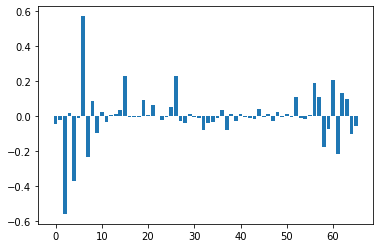

In [ ]:
# get importance
importance = logistic_reg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

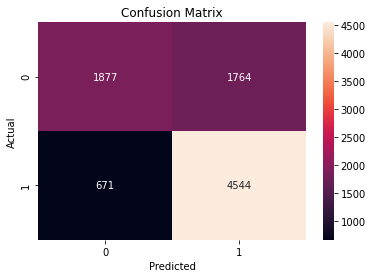

TP: 4544
TN: 1877
FP: 1764
FN: 671
Classification Accuracy: 0.7250451671183379
F1 Score: 0.7886835025600971
AUC Score: 0.6934252045324857


In [ ]:
accuracy_score_logistic_reg = model_evaluation(logistic_reg, ytest, y_pred_class, True)

model_scores['LogitClassifier'] = accuracy_score_logistic_reg[1] * 100


In [ ]:
logistic_reg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

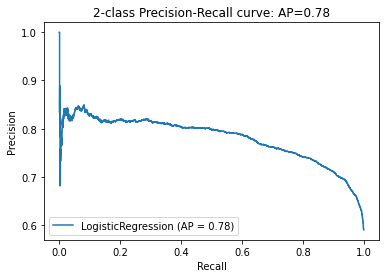

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import average_precision_score
y_score= logistic_reg.predict_proba(xtest)[:,1]

precision, recall, threshold = precision_recall_curve(ytest, y_score)
fpr, tpr, thresholds = roc_curve(ytest, y_score)

average_precision = average_precision_score(ytest, y_score)
disp = plot_precision_recall_curve(logistic_reg, xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

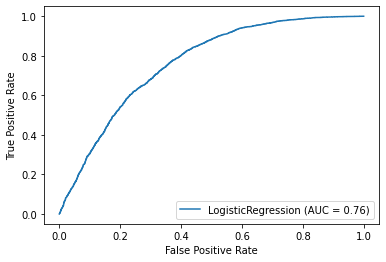

In [ ]:
plot_roc_curve(logistic_reg, xtest, ytest)
plt.show()

Text(0, 0.5, 'True Positive Rate')

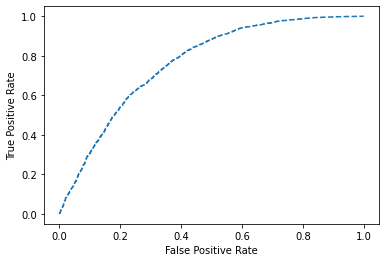

In [ ]:
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='No Skill')
#plt.plot(thresholds, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
def threshold_optimization(model_name, test_features, test_labels, thresholds_list):
  '''
  '''
  pred_proba_df = pd.DataFrame(model_name.predict_proba(test_features))
  for i in thresholds_list:
      print ('\n******** For Threshold = {} ******'.format(i))
      Y_test_pred = pred_proba_df[1].map(lambda x: 1 if x>i else 0)
      confusion = confusion_matrix(test_labels, Y_test_pred)
      TP = confusion[1, 1]
      TN = confusion[0, 0]
      FP = confusion[0, 1]
      FN = confusion[1, 0]
      f1= f1_score(test_labels, Y_test_pred)

      print('TP:', TP)
      print('TN:', TN)
      print('FP:', FP)
      print('FN:', FN)
      print(f'F-1 Score with threshold {i} is: {f1}')

In [ ]:
threshold_list = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
threshold_optimization(logistic_reg ,xtest, ytest, threshold_list)


******** For Threshold = 0.2 ******
TP: 5103
TN: 942
FP: 2699
FN: 112
F-1 Score with threshold 0.2 is: 0.7840516247983407

******** For Threshold = 0.3 ******
TP: 4939
TN: 1381
FP: 2260
FN: 276
F-1 Score with threshold 0.3 is: 0.79571451586918

******** For Threshold = 0.4 ******
TP: 4770
TN: 1617
FP: 2024
FN: 445
F-1 Score with threshold 0.4 is: 0.7944041968523609

******** For Threshold = 0.45 ******
TP: 4678
TN: 1748
FP: 1893
FN: 537
F-1 Score with threshold 0.45 is: 0.7938231800441202

******** For Threshold = 0.5 ******
TP: 4544
TN: 1877
FP: 1764
FN: 671
F-1 Score with threshold 0.5 is: 0.7886835025600971

******** For Threshold = 0.55 ******
TP: 4368
TN: 2054
FP: 1587
FN: 847
F-1 Score with threshold 0.55 is: 0.782094897045658

******** For Threshold = 0.6 ******
TP: 4075
TN: 2259
FP: 1382
FN: 1140
F-1 Score with threshold 0.6 is: 0.7636806596701649

******** For Threshold = 0.7 ******
TP: 3099
TN: 2809
FP: 832
FN: 2116
F-1 Score with threshold 0.7 is: 0.6776732998031927

******

<b>As classification threshold increse F-1 Score also increases. But False Negative (defaulter customer identified as good customer) also inreases. Which could be coslty to the business. An optimum threshold has to be chosen. </b>

(0.0, 1.0)

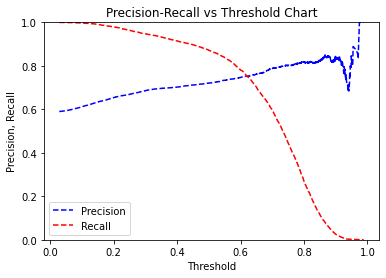

In [ ]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y=logistic_reg.predict(xtest) 

probs_y=logistic_reg.predict_proba(xtest) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first   column of  array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(ytest, probs_y[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## Neural Networks


In [ ]:
# Model using Artificial Neural Networks
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

#Fit ANN model to data
startTrain= time.time()
model = Sequential()
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 40, input_dim= 66))
model.add(Dropout(rate= 0.01))
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 40))
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 20))
model.add(Dense(activation = 'sigmoid', kernel_initializer= 'uniform', units =1))
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss= 'binary_crossentropy', metrics=['accuracy'])
model.fit(np.array(xtrain), np.array(ytrain), batch_size=32, epochs=100, callbacks=early_stopping_callback)
endTrain = time.time()



print("ANN training time (secs) {0}".format(endTrain - startTrain))

#Predicting using ANN
Ypred = model.predict_classes(np.array(xtest))



Epoch 1/100
646/646 [==============================] - 2s 2ms/step - loss: 0.6816 - accuracy: 0.5786
Epoch 2/100
646/646 [==============================] - 1s 1ms/step - loss: 0.6659 - accuracy: 0.5999
Epoch 3/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5740 - accuracy: 0.7221
Epoch 4/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5479 - accuracy: 0.7245
Epoch 5/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5413 - accuracy: 0.7296
Epoch 6/100
646/646 [==============================] - 1s 2ms/step - loss: 0.5344 - accuracy: 0.7320
Epoch 7/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.7305
Epoch 8/100
646/646 [==============================] - 1s 2ms/step - loss: 0.5360 - accuracy: 0.7276
Epoch 9/100
646/646 [==============================] - 1s 2ms/step - loss: 0.5314 - accuracy: 0.7315
Epoch 10/100
646/646 [==============================] - 1s 2ms/step - loss: 0.5293 - accura

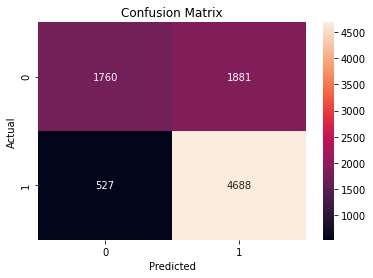

TP: 4688
TN: 1760
FP: 1881
FN: 527
Classification Accuracy: 0.7280939476061428
F1 Score: 0.7956551255940257
AUC Score: 0.6911645178763328


In [88]:
accuracy_score_NeuralNet = model_evaluation(model, np.array(ytest), Ypred, True)

model_scores['NueralNets'] = accuracy_score_NeuralNet[1] * 100

# Performance Comparison

In [90]:
model_scores

{'LogitClassifier': 69.34252045324857,
 'NueralNets': 69.11645178763328,
 'Random Forest': 71.08724990210827,
 'XGBClassifier': 70.55822115393478,
 'XGBoost_CV': 70.79686630610209}

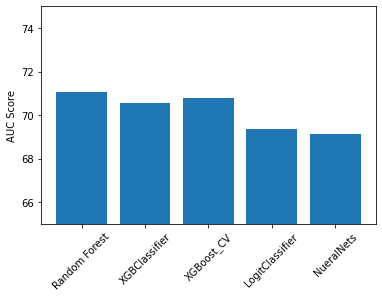

In [91]:
names = list(model_scores.keys())
values = list(model_scores.values())
plt.bar(range(len(model_scores)), values, tick_label=names)
plt.xticks(rotation=45)
plt.ylabel('AUC Score')
plt.ylim([65.0, 75.0])
plt.show()

<b>XGBoost has performed better in the validation dataset in terms of AUC Score. </b>


In [92]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=logistic_reg, estimator2=random_forest, X=xtest, y=ytest, scoring='accuracy', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

P-value: 0.712, t-Statistic: -0.390
Algorithms probably have the same performance


In [93]:
# Selection of features based on feature importance scores by different models
cols= ['apr', 'clearfraudscore', 'ssnLoanCount', 'log_loanAmount', 'log_nPaidOff',
       'payFrequency_B', 'payFrequency_I', 'payFrequency_M', 'payFrequency_S', 'payFrequency_W']

# Separate input features and target
x_data_selected = data[cols]
y_data = data['target'].astype('category')

In [94]:
# Shuffle and split data into 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data_selected, y_data,random_state=123, test_size=0.30)

In [95]:
#training a new lighter Logistic Regression with selected features
log_reg_selected_features= LogisticRegression()
log_reg_selected_features.fit(x_train, y_train)
y_pred_class = log_reg_selected_features.predict(x_test)
log_reg_selected_features.score(x_test,y_test)

0.7121725383920506

In [96]:
import pickle
# open a file, where to store the data
file = open('logistic_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(logistic_reg, file)

In [98]:
# Save the evironment in requirements.txt file
!pip install pipreqs
import pipreqs
!pipreqs --force './'

INFO: Successfully saved requirements file in ./requirements.txt


In [99]:
!pip freeze > requirements1.txt

## Improvements
*This analysis has been carried out based on the data available from previous loan accounts, which are mostly related to the individual borrower. There may be other factors/features that could better predict the credit risks. Country-related risks such as sudden political instability or downfall of the overall economic situation of the country may affect a person or entity's ability to repay the loan. Other cases, such as the invention of new technology, can kill a traditional industry. Businesses and people working in that industry will suddenly become jobless. These situations will impact their ability to repay the loan even if they had a perfect credit history or paid off the loan on time in the past.

*The financial institutions, banks, and lenders can adjust the cost of credit, carry out risk-based pricing, reduce credit amount to the high-risk buyers, tight the credit provision, purchase the credit insurance or derivatives, and much more to curb the menace.

*Many studies have found debt to income ratio is a clear indicator of the borrowers' ability to repay the loan. Including customer income, data could improve the model.

*Feature Selection was not done for Neural Network Model. Important features identified from Random Forest and XGBoost can be used to reduce the dimension.

*There are no straight forward rule for Neural Network model architecture. It requires more trial and error to come up with a better model.

*Random Forest itself a kind of ensemble model. Stacking modeling methods (train different models and use their predictions as features in another model) could be used for better performance.

*QuantileTransformer reduces the effect of outlier. However,  completely removing outliers from the dataset could improve the model.


*Reduce false positives and false negatives. It depends on the business objectives, which one to prioritize. If the business goal is to reduce loss, then falsely identifying a customer as good but who is actually a defaulter could lead to capital loss. Again, falsely classifying a defaulter who is actually a good customer, is an opportunity loss.

## Summary
In this report, we achieved 0.71 AUC score in determining whether a loan will be defaulted or not. We explored past loan performance and understood what kind of people are more likely to default. Random Forest has performed better in the validation dataset in terms of AUC Score.However, the differences in accuracy between these models are not significant.

We have used some selected features to create a loan prediction app for demonstration purpose. 
